One of the most obvious features of the data presented in the [previous notebook](/medalla-validator-taxonomy) was the crash in participation rate which occurred at the time of the [roughtime incident](https://medium.com/prysmatic-labs/eth2-medalla-testnet-incident-f7fbc3cc934a). A number of important lessons were identified from this incident, such as:
- the importance of client diversity;
- the perils of depending on centralised service providers for consensus-critical information;
- the value of easy and seemless switching between clients for validators;
- the importance of rigorous release testing, even (especially) during a crisis;
- \[and many others\].
But of course, Medalla is a testnet, and exposing such potential weaknesses is one of the main reasons for running it. From the perspective of getting data and improving our understanding of how the network behaves under severe stress, it was an unexpected gift.

We've already seen from the impact on the participation rate one of the ways in which network stress can manifest itself. In this notebook, we will look at a series of other metrics which may contain valuable information about network performance, providing cues about bugs or other problems.

In [1]:
# imports
import time

import psycopg2
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
from IPython.display import display

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [3]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed, "
               "f_first_attested_epoch, f_latest_attested_epoch FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3],
               "first_attestation"           : r[4],
               "latest_attestation"          : r[5]} for r in result]

## Attestation metrics

In [13]:
# calculate mean inclusion distance, mean attestation effectiveness, attestation accuracy metrics

start_time = time.time()
last_update = 0

empty = [0] * n_epochs
success_count      = empty.copy()
unresponsive_count = empty.copy()
missed_count       = empty.copy()
correct_count      = empty.copy()
sum_distance       = empty.copy()
sum_ae             = empty.copy()

for slot in range(n_epochs * 32):
    cursor.execute(f"SELECT f_validator_index, f_performance, f_effectiveness, f_correct "
                   f"FROM t_validator_performance WHERE f_slot = {slot}")
    result = cursor.fetchone()
    validator_indices  = result[0]
    performance        = result[1]
    effectiveness      = result[2]
    correct            = result[3]
    
    epoch = slot // 32
    for position, val_index in enumerate(validator_indices):
        if performance[position] != -1:
            success_count[epoch]      += 1
            sum_distance[epoch]       += performance[position]
            sum_ae[epoch]             += effectiveness[position]
            if correct[position] == 1:
                correct_count[epoch] += 1
        elif (validators[val_index]["latest_attestation"] == -1
              or epoch < validators[val_index]["first_attestation"]
              or epoch > validators[val_index]["latest_attestation"]):
            unresponsive_count[epoch] += 1
        else:
            missed_count[epoch]       += 1

    t = time.time()
    if t - last_update > 0.1:
        last_update = t
        seconds = t - start_time
        elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
        left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
        percentage = 100*(slot+1)/(latest_slot+1)
        print(f"epoch {epoch} of {latest_slot//32} ({percentage:.2f}%) / "
              f"{elapsed} elapsed / {left} left", end='\r')

mean_inclusion_distance = [sum_distance[e] / success_count[e] if success_count[e] > 0 else None
                       for e in range(n_epochs)]

mean_ae = [100 * sum_ae[e] / (success_count[e] + missed_count[e]) if success_count[e] > 0 else 0
           for e in range(n_epochs)]

accuracy = [100 * correct_count[e] / success_count[e] if success_count[e] > 0 else 0
            for e in range(n_epochs)]

print(f"completed in {elapsed}." + ' ' * 80)

completed in 00:18:03.                                                                                


## Participation Rate
We looked at the participation rate in the previous notebook. It's plotted again below, excluding unresponsive validators (this time as a line graph for easier comparison).

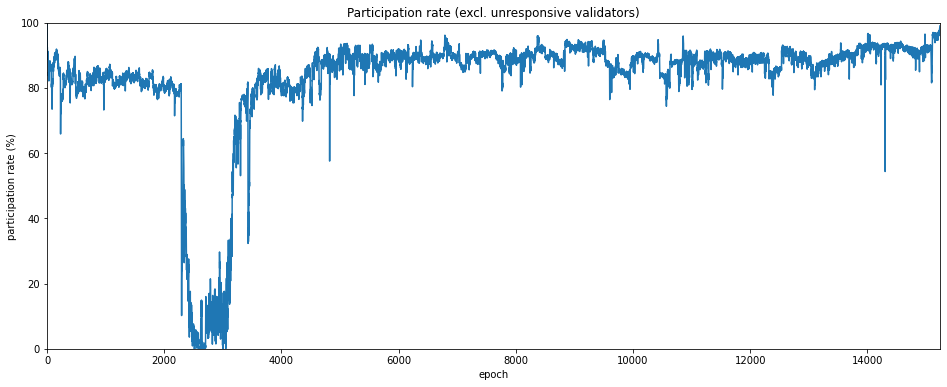

In [14]:
# plot participation rate

participation_rate = [100 * s / (s + missed_count[i]) for i, s in enumerate(success_count)]
participation_rate_series = pd.Series(participation_rate)

fig=plt.figure(figsize=(16,6))
plt.plot(participation_rate_series)
plt.margins(0,0)
plt.title('Participation rate (excl. unresponsive validators)')
plt.xlabel('epoch')
plt.ylabel('participation rate (%)')
plt.show()

## Mean inclusion distance
Another metric we can use to look at the health of the network is how quickly validators are able to have their attestations included into the beacon chain. As mentioned above, this is called the *inclusion distance*, which is the number of slots it takes for an attestatation to be included in a canonical block. By averaging this across all validators who successfully attested in a given epoch, we get a quantity called the *mean inclusion distance*. We already calculated this in the second pass through attestations above.

Unsurprisingly, the mean inclusion distance jumps significantly around the roughtime incident. But interestingly there are a number of smaller spikes. A particularly large spike around epoch 4800 for example (shown in greater detail in the second graph), which could be an indication of a networking problem or bug which merits closer attention.

Looking just at the period from epoch 5000 onwards, we can see the average (mean) of the mean inclusion distance is around 0.4, suggesting that the majority of successful attestations are included in the beacon chain with an inclusion distance of 0 (i.e. at the first opportunity).

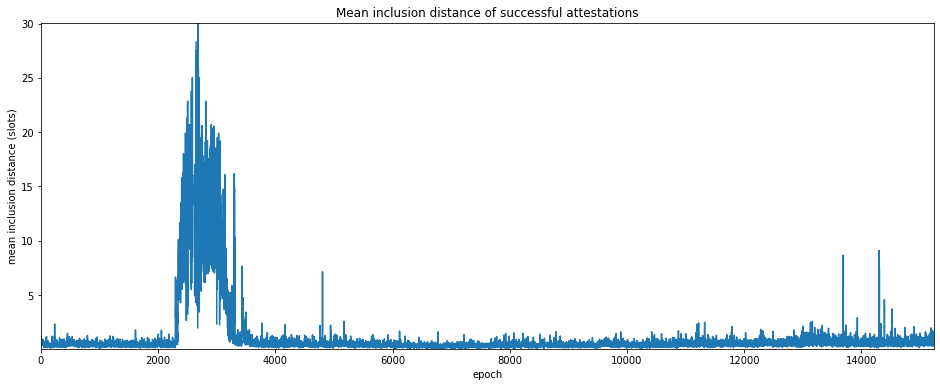

In [15]:
# graphs and stats for mean inclusion distance

mid_series = pd.Series(mean_inclusion_distance, name="mean inclusion distance")

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(mid_series)
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestations')
plt.xlabel('epoch')
plt.ylabel('mean inclusion distance (slots)')
plt.show()

## Attestation Effectiveness
A metric that effectively combines participation rate and inclusion distance into a single score describing a validator's performance is *attestation effectiveness*, which has been defined by [Jim McDonald](https://www.attestant.io/posts/defining-attestation-effectiveness/) as the ratio between the maximum reward a validator could have received for full prompt participation, and the reward they actually received. The protocol penalises late attestations, scaling the attestation reward by the inverse of the inclusion distance.\*

\* For attestation effectiveness, the inclusion distance is measured from the first slot containing a valid block, since attestations will be delayed if a slot is empty, through no fault of the validator.

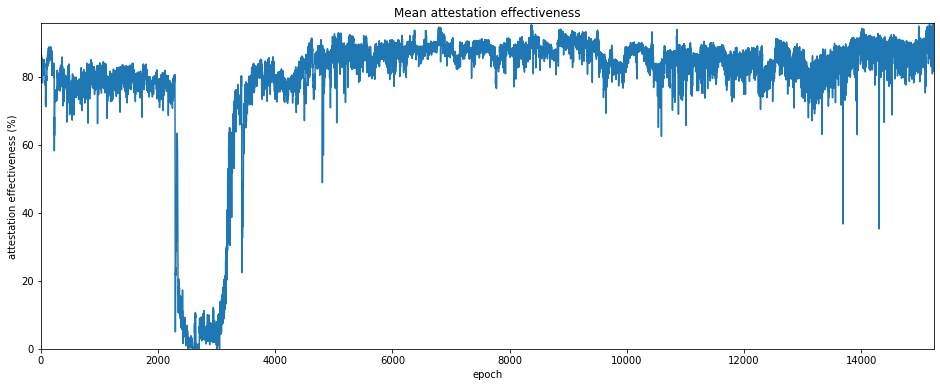

In [16]:
# plot attestation effectiveness

mean_ae_series = pd.Series(mean_ae, name="mean attestation effectiveness")

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(mean_ae_series)
plt.margins(0,0)
plt.title('Mean attestation effectiveness')
plt.xlabel('epoch')
plt.ylabel('attestation effectiveness (%)')
plt.show()

## Attestation Accuracy

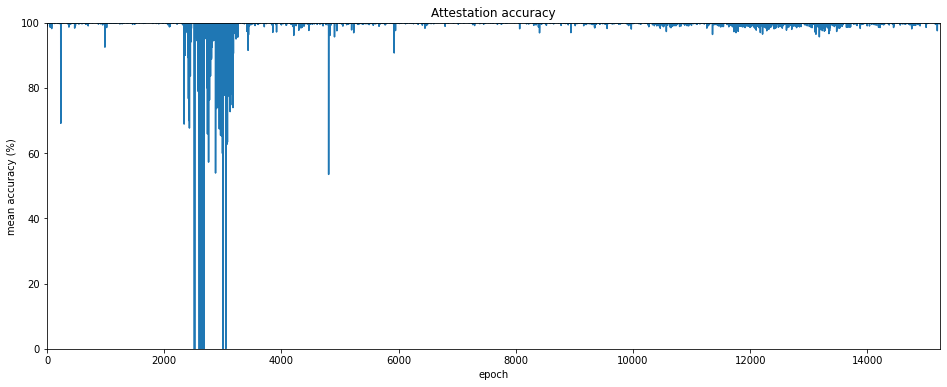

In [20]:
# plot accuracy rate by epoch

accuracy_series = pd.Series(accuracy)

# plot accuracy
fig=plt.figure(figsize=(16,6))
plt.plot(accuracy_series)
plt.margins(0,0)
plt.title('Attestation accuracy')
plt.xlabel('epoch')
plt.ylabel('mean accuracy (%)')
plt.show()

## Block Production Metrics (Empty Slots and Orphaned Blocks)
The data in the `chaind` database includes some *orphaned* (or equivalently *non-canonical*) blocks — i.e. blocks which were not finalised by the consensus process. Blocks may be orphaned when networking or other problems prevent them being visible to all nodes, accordingly they are yet another indicator of network health, as shown by the large increase in orphaned blocks around the roughtime incident.

In [9]:
# count orphaned blocks

cursor.execute("SELECT COUNT(*), SUM(f_canonical::int) FROM t_blocks")
n_blocks, n_canonical = cursor.fetchone()
n_orphaned = n_blocks - n_canonical
print(f"Dataset contains {n_blocks} blocks of which {n_orphaned} ({100*(n_orphaned/n_blocks):.1f}%) orphaned")

# count empty slots

cursor.execute("SELECT COUNT(*) FROM t_blocks WHERE f_canonical")
n_empty = n_slots - cursor.fetchone()[0]
print(f"Dataset encompases {n_slots} slots of which {n_empty} ({100*(n_empty/n_slots):.1f}%) were empty")

Dataset contains 358048 blocks of which 8192 (2.3%) orphaned
Dataset encompases 487601 slots of which 137745 (28.2%) were empty


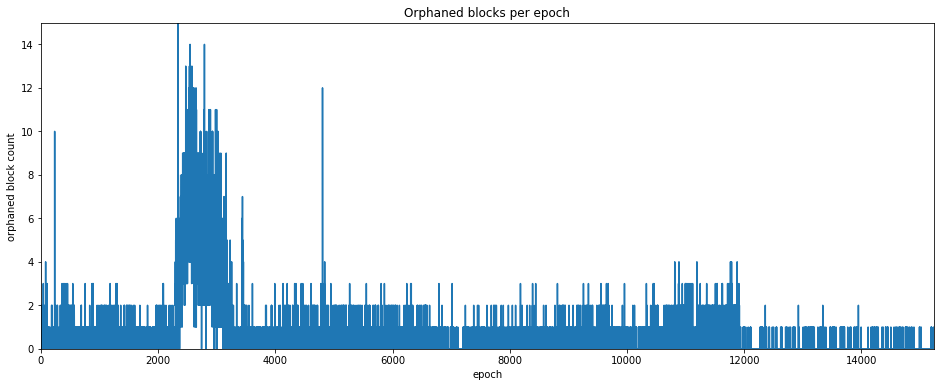

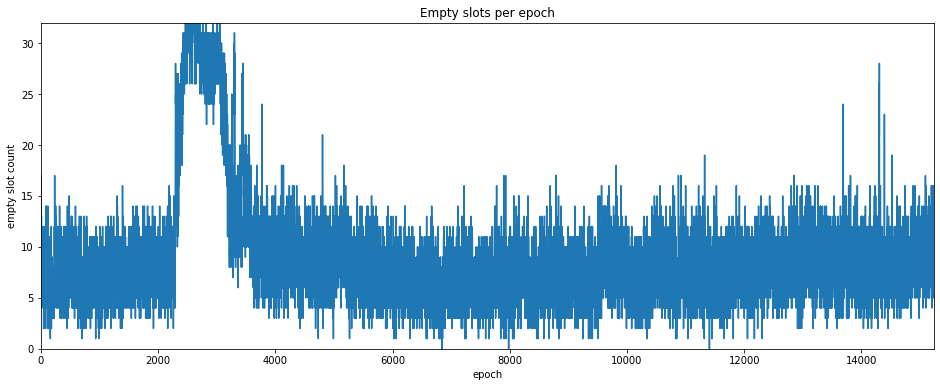

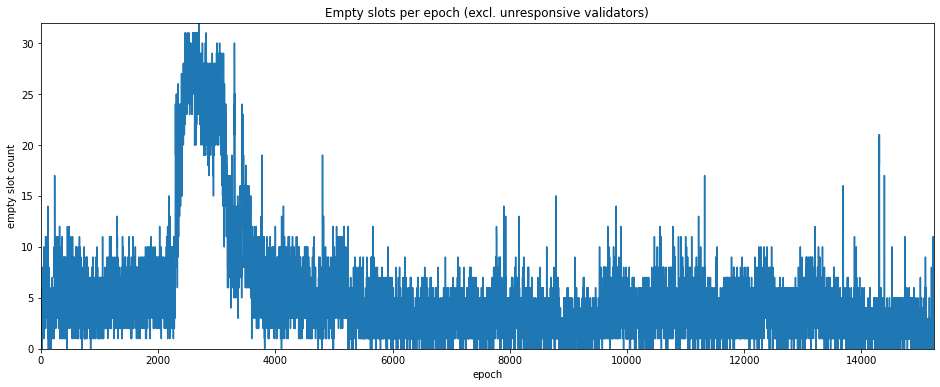

In [10]:
# plot empty slots and orphaned blocks by epoch

cursor.execute("SELECT f_slot FROM t_blocks WHERE NOT f_canonical")
result = cursor.fetchall()
orphaned_count = [0] * n_epochs
for el in result:
    orphaned_count[el[0] // 32] += 1
    
orphaned_blocks_series = pd.Series(orphaned_count)

# plot orphan count
fig=plt.figure(figsize=(16,6))
plt.plot(orphaned_blocks_series)
plt.margins(0,0)
plt.title('Orphaned blocks per epoch')
plt.xlabel('epoch')
plt.ylabel('orphaned block count')
plt.show()

empty_slots = [True] * n_slots
cursor.execute("SELECT f_slot FROM t_blocks WHERE f_canonical")
result = cursor.fetchall()
for el in result:
    empty_slots[el[0]] = False

empty_count = [0] * n_epochs
for slot in range(0, n_epochs * 32, 32):
    empty_count[slot // 32] = sum(empty_slots[slot:slot+32])
    
empty_count_series = pd.Series(empty_count)

# plot empty count
fig=plt.figure(figsize=(16,6))
plt.plot(empty_count_series)
plt.margins(0,0)
plt.title('Empty slots per epoch')
plt.xlabel('epoch')
plt.ylabel('empty slot count')
plt.show()

# repeat empty slot analysis but ignore unresponsive proposers

cursor.execute("SELECT f_slot, f_validator_index FROM t_proposer_duties")
result = cursor.fetchall()
proposer_responsive = [False] * n_slots
for el in result:
    slot = el[0]
    if slot > latest_slot:
        continue
    epoch = slot // 32
    validator = validators[el[1]]
    if epoch >= validator["first_attestation"] and epoch <= validator["latest_attestation"]:
        proposer_responsive[slot] = True

empty_slots_responsive = [empty and proposer_responsive[i] for i, empty in enumerate(empty_slots)]

empty_responsive_count = [0] * n_epochs
for slot in range(0, n_epochs * 32, 32):
    empty_responsive_count[slot // 32] = sum(empty_slots_responsive[slot:slot+32])
    
empty_responsive_count_series = pd.Series(empty_responsive_count)

# plot empty (responsive) count
fig=plt.figure(figsize=(16,6))
plt.plot(empty_responsive_count_series)
plt.margins(0,0)
plt.title('Empty slots per epoch (excl. unresponsive validators)')
plt.xlabel('epoch')
plt.ylabel('empty slot count')
plt.show()

## Slashing Events

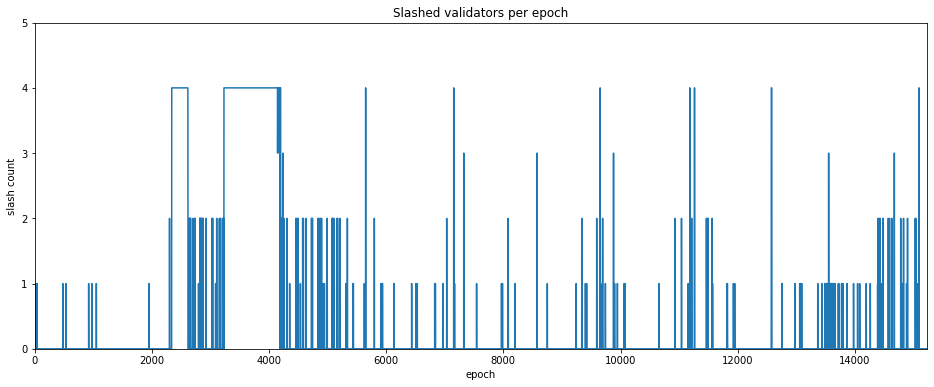

In [11]:
# count up slashing events, plot per epoch

slashed_count = [0] * n_epochs
slashed_epochs = [v["exit_epoch"] for v in validators if v["slashed"]]
for epoch in slashed_epochs:
        slashed_count[epoch] += 1
    
slashed_count_series = pd.Series(slashed_count)
    
# plot slashed count
fig=plt.figure(figsize=(16,6))
plt.plot(slashed_count_series)
plt.margins(0,0)
plt.title('Slashed validators per epoch')
plt.xlabel('epoch')
plt.ylabel('slash count')
plt.yticks(range(6))
plt.show()

## Conclusions